In [1]:
import argparse
import os
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import skimage
import tifffile
from arg_parsing_utils import check_for_missing_args, parse_args
from file_reading import find_files_available, read_in_channels, read_zstack_image
from notebook_init_utils import bandicoot_check, init_notebook
from nuclei_segmentation import *

from segmentation_utils import *

In [2]:
start_time = time.time()
# get starting memory (cpu)
start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2

In [3]:
root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [4]:
if not in_notebook:
    args = parse_args()
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "C4-2"
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"


window_size = 2
input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}"
).resolve(strict=True)
mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)

Running in a notebook


In [5]:
if in_notebook:
    return_dict = read_in_channels(
        find_files_available(input_dir),
        channel_dict={
            "DNA": "405",
            "cyto1": "488",
            "cyto2": "555",
            "cyto3": "640",
            "brightfield": "TRANS",
        },
        channels_to_read=[],
    )
    DNA_raw = return_dict["DNA"]
nuclei_mask_path = pathlib.Path(f"{mask_path}/nuclei_mask.tiff")
nuclei_mask = read_zstack_image(nuclei_mask_path)

In [6]:
ref_objects = nuclei_mask.copy()

## Run u-segment3D to reassign labels to single nuclei objects

In [7]:
import segment3D.file_io as uSegment3D_fio
import segment3D.filters as uSegment3D_filters
import segment3D.flows as uSegment3D_flows
import segment3D.parameters as uSegment3D_params  # this is useful to call default parameters, and keep track of parameter changes and for saving parameters.
import segment3D.plotting as uSegment3D_plotting
import segment3D.segmentation as uSegment3D_segment
import segment3D.usegment3d as uSegment3D
import segment3D.watershed as uSegment3D_watershed

In [8]:
"""
Generate the 2D slice labels.
- this transposes the input  volume into xy, xz, yz stacks, then goes slice-by-slice and ensures every ID corresponds to one spatial connected component.
"""
# xy
labels_xy = ref_objects.copy()
labels_xy = uSegment3D_filters.filter_2d_label_slices(labels_xy, bg_label=0, minsize=8)

# xz
labels_xz = ref_objects.transpose(1, 0, 2).copy()
labels_xz = uSegment3D_filters.filter_2d_label_slices(labels_xz, bg_label=0, minsize=8)

# xy
labels_yz = ref_objects.transpose(2, 0, 1).copy()
labels_yz = uSegment3D_filters.filter_2d_label_slices(labels_yz, bg_label=0, minsize=8)

In [9]:
# Get the default parameters.
indirect_aggregation_params = uSegment3D_params.get_2D_to_3D_aggregation_params()

# Set the indirect parameters, such as choice of distance transform and adjusting gradient descent parameters.

# choice of transforms and its computation parameters:

# e.g. using diffusion centroid
# indirect_aggregation_params['indirect_method']['dtform_method'] = 'cellpose_improve' # this will use our exact solver of heat equation. with a fixed central point
# # indirect_aggregation_params['indirect_method']['dtform_method'] = 'fmm' # this will Fast marching. with a fixed central point
# indirect_aggregation_params['indirect_method']['edt_fixed_point_percentile'] = 0.01
# indirect_aggregation_params['gradient_descent']['gradient_decay'] = 0.25 # we used 0.0 for cellpose_improve in the paper, 0.25 seems better.

# # e.g. using  diffusion skeleton
indirect_aggregation_params["indirect_method"]["dtform_method"] = (
    "cellpose_skel"  # this will use our exact solver of heat equation. with a fixed central point
)
# indirect_aggregation_params['indirect_method']['dtform_method'] = 'fmm_skel' # this will use our exact solver of heat equation. with a fixed central point
indirect_aggregation_params["indirect_method"]["smooth_skel_sigma"] = (
    1  # 1 or 2 is good ?
)
indirect_aggregation_params["gradient_descent"]["gradient_decay"] = (
    0.25  # we used 0.0 for cellpose_improve in the paper
)

# # e.g. using EDT
# indirect_aggregation_params['indirect_method']['dtform_method'] = 'edt' # this will use our exact solver of heat equation. with a fixed central point
# indirect_aggregation_params['gradient_descent']['gradient_decay'] = 0.5 # we used 0.5 for EDT in the paper


# set the gradient descent parameters
indirect_aggregation_params["gradient_descent"]["n_iter"] = 250
indirect_aggregation_params["gradient_descent"]["momenta"] = (
    0.98  # help boost the splitting
)

# we can visualize the dynamics
indirect_aggregation_params["gradient_descent"]["debug_viz"] = False

In [10]:
segmentation3D, (probability3D, gradients3D) = (
    uSegment3D.aggregate_2D_to_3D_segmentation_indirect_method(
        segmentations=[
            labels_xy,
            labels_xz,
            labels_yz,
        ],
        img_xy_shape=ref_objects.shape,
        precomputed_binary=ref_objects > 0,  # we know the foreground
        params=indirect_aggregation_params,
        savefolder=None,
        basename=None,
    )
)

/home/lippincm/miniforge3/envs/u_segment3d_env/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 446.96 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/lippincm/miniforge3/envs/u_segment3d_env/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 447.34 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
100%|██████████| 250/250 [00:24<00:00, 10.09it/s]


In [11]:
# remove small objects
segmentation3D = uSegment3D_filters.remove_small_labels(segmentation3D, min_size=250)

In [12]:
nuclei_mask_output = pathlib.Path(f"{mask_path}/nuclei_mask_usegment.tiff")
tifffile.imwrite(nuclei_mask_output, segmentation3D)

In [13]:
import scipy

# Erode to separate touching objects, then watershed
eroded = skimage.morphology.binary_erosion(
    segmentation3D > 0,
    skimage.morphology.ball(2),  # Adjust radius
)
markers = nuclei_mask
markers[segmentation3D == 0] = 0

segmentation3D_watershed = skimage.segmentation.watershed(
    -scipy.ndimage.distance_transform_edt(segmentation3D > 0),
    markers=markers,
    mask=segmentation3D > 0,
)
nuclei_mask_output = pathlib.Path(f"{mask_path}/nuclei_mask_usegment_watershed.tiff")
tifffile.imwrite(nuclei_mask_output, segmentation3D_watershed)

In [14]:
# generate the coordinates dataframe for reconstruction
coordinates_df = generate_coordinates_for_reconstruction(segmentation3D_watershed)
# generate distance pairs dataframe
df = generate_distance_pairs(coordinates_df, x_y_vector_radius_max_constraint=20)
# generate and solve graph to get longest paths
longest_paths = solve_graph(graph_creation(df))
# collapse labels based on longest paths and reassign labels in nuclei masks
image = reassign_labels(
    segmentation3D_watershed, collapse_labels(coordinates_df, longest_paths)
)
# refine the nuclei masks
segmentation3D_watershed_reassigned = run_post_hoc_refinement(
    mask_image=image,
    sliding_window_context=3,
)

nuclei_mask_output = pathlib.Path(
    f"{mask_path}/nuclei_mask_usegment_watershed_reassigned.tiff"
)
tifffile.imwrite(nuclei_mask_output, segmentation3D_watershed_reassigned)

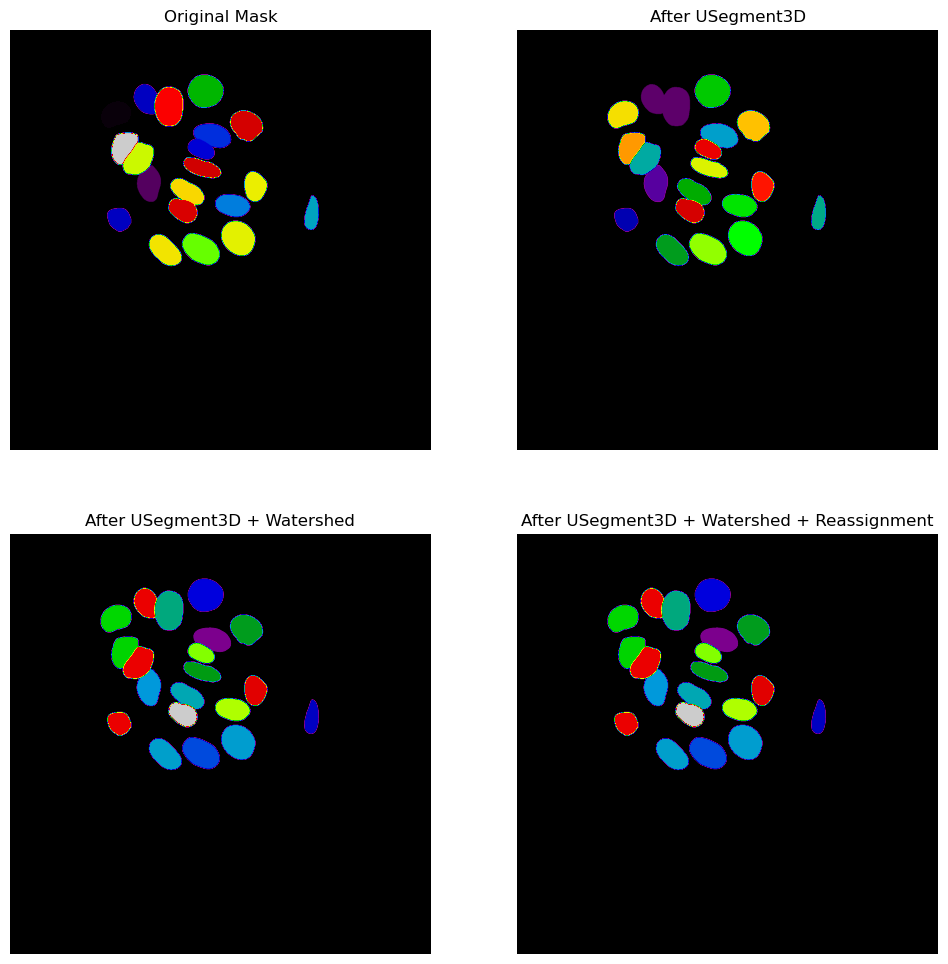

In [15]:
import matplotlib.pyplot as plt

z = 8
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.imshow(ref_objects[z], cmap="nipy_spectral")
plt.title("Original Mask")
plt.axis("off")
plt.subplot(222)
plt.imshow(segmentation3D[z], cmap="nipy_spectral")
plt.title("After USegment3D")
plt.axis("off")
plt.subplot(223)
plt.imshow(segmentation3D_watershed[z], cmap="nipy_spectral")
plt.title("After USegment3D + Watershed")
plt.axis("off")
plt.subplot(224)
plt.imshow(segmentation3D_watershed_reassigned[z], cmap="nipy_spectral")
plt.title("After USegment3D + Watershed + Reassignment")
plt.axis("off")
plt.show()